In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize 
from nltk import ngrams
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix

## Загрузка данных

In [2]:
# все данные
data_fintext = pd.read_excel('База данных.xlsx', sheet_name = 'Данные', nrows=393)

# текст для векторизации
data_text = data_fintext[['text', 'fraud']]

# фин показатели: отделяем, выбираем нужные столбцы, переименовываем, берем логарифмы нужных
data_fin = data_fintext.drop(columns = ['название', 'year', 'text', 'sector'], axis=1)
data_fin['lnTA'] = np.log(data_fin['Total Assets'])
data_fin['lnCDCA'] = np.log(data_fin['Current Debt /Current Assets'])
data_fin['lnR'] = np.log(data_fin['Revenue'])
data_fin = data_fin.drop(columns = ['Total Assets', 'Revenue'], axis=1)

data_fin['NI/R'] = data_fin['Net Income/Revenue']
data_fin['EBIT/TA'] = data_fin['EBIT/Total Assets']
data_fin['FA/TA'] = data_fin['Fixed Assets /Total Assets']

In [3]:
data_fin = data_fin[['lnTA', 'EBIT/TA', 'NI/R',
                     'FA/TA', 'fraud', 'lnCDCA']]

data_tone = pd.read_csv('x_model1.csv')
data_tone = data_tone.drop(columns = ['Unnamed: 0'], axis=1)

data_fintone = data_fin.join(data_tone)
corr = data_fintone.corr()
corr.style.background_gradient(cmap='Blues')
corr.style.background_gradient(cmap='Blues').to_excel('corr.xlsx')

In [4]:
data_tone1 = pd.read_csv('x_model1.csv')
data_tone1 = data_tone1.drop(columns = ['Unnamed: 0'], axis=1)
data_tone1.describe()

,pos_proportion,neg_proportion,tonality,unc_proportion,cons_proportion,lit_proportion,modstrong_proportion,modweak_proportion,fog_index,wordcount,complex_pr,words_ps
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,0.052540,0.016014,0.530042,0.006345,0.004983,0.003340,0.003590,0.002275,20.112495,1612.090674,0.261471,24.134155
std,0.016094,0.009597,0.255699,0.004057,0.003679,0.003448,0.002642,0.002133,1.955166,837.825856,0.029882,3.254983
min,0.015385,0.000000,-0.403509,0.000000,0.000000,0.000000,0.000000,0.000000,14.060467,286.000000,0.173913,15.316456
25%,0.041731,0.009466,0.400000,0.003199,0.002454,0.000914,0.001779,0.000697,18.766055,1018.000000,0.241519,22.012027
50%,0.050675,0.014698,0.569498,0.005672,0.004216,0.002417,0.003159,0.001813,20.089604,1398.500000,0.259441,23.799551
75%,0.060812,0.021093,0.709881,0.008628,0.006880,0.004899,0.004995,0.003425,21.379138,1970.750000,0.283012,26.031250
max,0.109091,0.053942,1.000000,0.019567,0.021886,0.017370,0.013871,0.012220,26.438648,5133.000000,0.349892,37.854545


In [5]:
data_fin.rename(columns = {'NI/R' : 'NIR', 'TA/R' : 'TAR', 'Cash/R' : 'CashR', 
                           'FA/TA' : 'FATA', 'NCWC t' : 'NCWC', 'NCWC/R' : 'NCWCR',
                           'CD/TA': 'CDTA', 'EBIT/TA': 'EBITTA', 'CD/CA' : 'CDCA'}, inplace = True )

# тональность текста
data_tone = pd.read_csv('x_model1.csv')
data_tone = data_tone.drop(columns = ['Unnamed: 0',   'tonality', 'modstrong_proportion',
                                      'words_ps', 'complex_pr', 'modweak_proportion', 'lit_proportion'], axis=1)

In [6]:
#data_fintone = data_fintone.drop('CDCA', axis=1)

In [7]:
# соединяем фин признаки и признаки тональности
data_fintone = data_fin.join(data_tone)
data_fraud = data_fintone['fraud']
data_fintone = data_fintone.drop('fraud', axis=1)

### Сравниваем качество моделей до/после соединения FIN + TEXT

In [8]:
# строим модели для проверки на значимость
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.discrete.discrete_model as smd

data_tone = sm.add_constant(data_tone, prepend=True, has_constant='skip')
results = smd.Logit(data_fraud, data_tone).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.548916
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:                  386
Model:                          Logit   Df Residuals:                      379
Method:                           MLE   Df Model:                            6
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.02632
Time:                        00:40:18   Log-Likelihood:                -211.88
converged:                       True   LL-Null:                       -217.61
Covariance Type:            nonrobust   LLR p-value:                   0.07529
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.0823      1.312     -1.587      0.112      -4.653       0.489
pos_proportion

In [9]:
data_fin = sm.add_constant(data_fin, prepend=True, has_constant='skip')
data_fin = data_fin.drop(columns = ['fraud'], axis=1)

results = smd.Logit(data_fraud, data_fin).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.526676
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:                  386
Model:                          Logit   Df Residuals:                      380
Method:                           MLE   Df Model:                            5
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.06577
Time:                        00:40:18   Log-Likelihood:                -203.30
converged:                       True   LL-Null:                       -217.61
Covariance Type:            nonrobust   LLR p-value:                 2.747e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.1997      1.706     -4.807      0.000     -11.543      -4.856
lnTA           0.3190      0.

## Корреляция

In [10]:
corr = data_fintone.corr()
corr.style.background_gradient(cmap='Blues')
corr.style.background_gradient(cmap='Blues').to_excel('corr.xlsx')

### Создаем константу для логистичекой регрессии

In [11]:
# строим модели для проверки на значимость
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.discrete.discrete_model as smd

data_fintone = sm.add_constant(data_fintone, prepend=True, has_constant='skip')
results = smd.Logit(data_fraud, data_fintone).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.507806
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:                  386
Model:                          Logit   Df Residuals:                      374
Method:                           MLE   Df Model:                           11
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.09924
Time:                        00:40:18   Log-Likelihood:                -196.01
converged:                       True   LL-Null:                       -217.61
Covariance Type:            nonrobust   LLR p-value:                 1.006e-05
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -9.9154      2.576     -3.850      0.000     -14.964      -4.867
lnTA          

In [12]:
data_fintone = data_fintone.drop('const', axis=1)

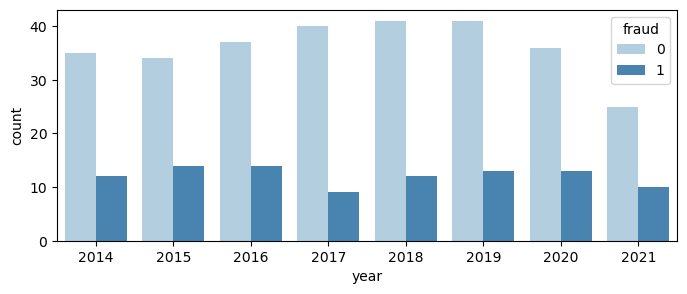

In [13]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.countplot(x='year', hue='fraud', data=data_fintext, palette = 'Blues', ax = ax);

In [14]:
data_fintone.describe()

,lnTA,EBITTA,NIR,FATA,lnCDCA,pos_proportion,neg_proportion,unc_proportion,cons_proportion,fog_index,wordcount
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,19.524410,0.090810,0.087746,0.573036,0.125595,0.052540,0.016014,0.006345,0.004983,20.112495,1612.090674
std,1.507376,0.303286,0.153366,0.231852,0.606484,0.016094,0.009597,0.004057,0.003679,1.955166,837.825856
min,14.182928,-5.195041,-0.821643,0.016057,-1.994215,0.015385,0.000000,0.000000,0.000000,14.060467,286.000000
25%,18.481744,0.056615,0.020647,0.443357,-0.288938,0.041731,0.009466,0.003199,0.002454,18.766055,1018.000000
50%,19.597710,0.085938,0.069856,0.601324,0.082356,0.050675,0.014698,0.005672,0.004216,20.089604,1398.500000
75%,20.286442,0.148109,0.154285,0.727855,0.555791,0.060812,0.021093,0.008628,0.006880,21.379138,1970.750000
max,24.020850,0.896425,1.003099,1.147197,2.414438,0.109091,0.053942,0.019567,0.021886,26.438648,5133.000000


### Распределение финансовых переменных

In [16]:
#sns_plot = sns.distplot(data_fintext['TA'])
#fig = sns_plot.get_figure()

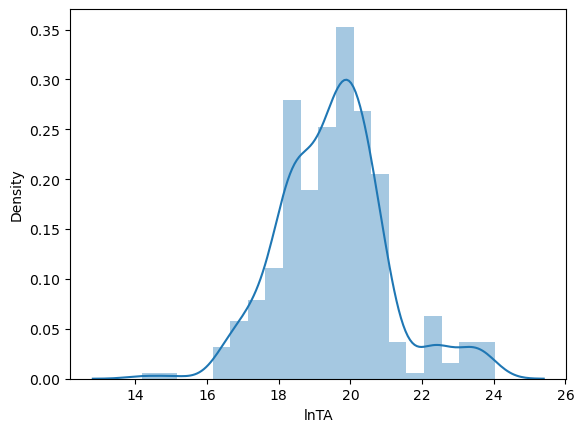

In [17]:
sns_plot = sns.distplot(data_fintone['lnTA'])
fig = sns_plot.get_figure()

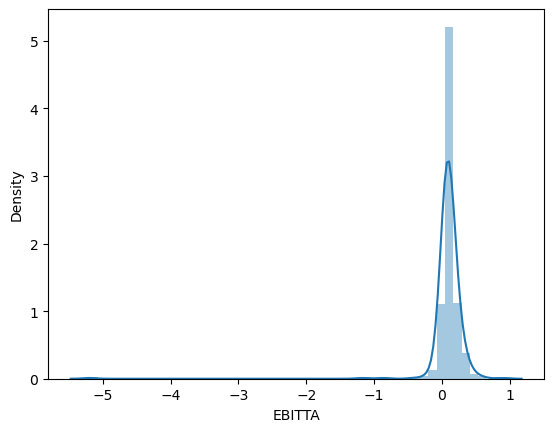

In [18]:
sns_ploft = sns.distplot(data_fintone['EBITTA'])
fig = sns_plot.get_figure()

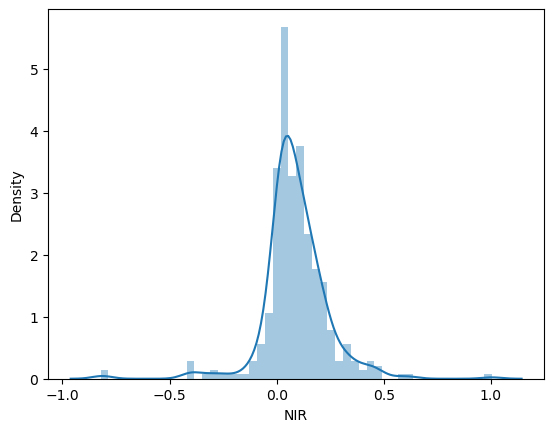

In [19]:
sns_plot = sns.distplot(data_fintone['NIR'])
fig = sns_plot.get_figure()

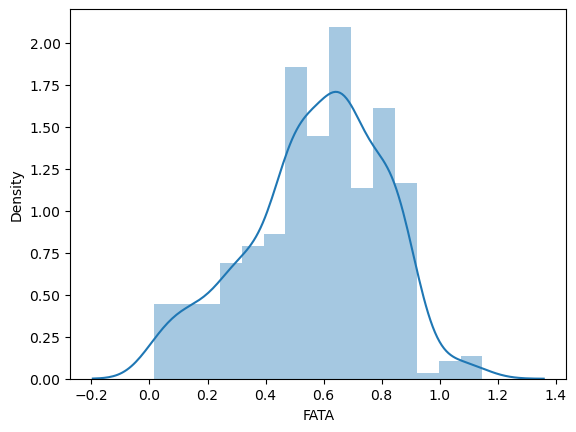

In [20]:
sns_plot = sns.distplot(data_fintone['FATA'])
fig = sns_plot.get_figure()

In [22]:
#sns_plot = sns.distplot(data_fintone['CDCA'])
#fig = sns_plot.get_figure()

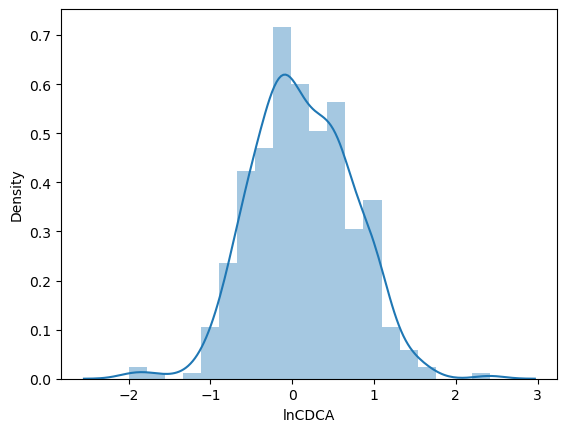

In [23]:
sns_plot = sns.distplot(data_fintone['lnCDCA'])
fig = sns_plot.get_figure()

### Распределение переменных тональности

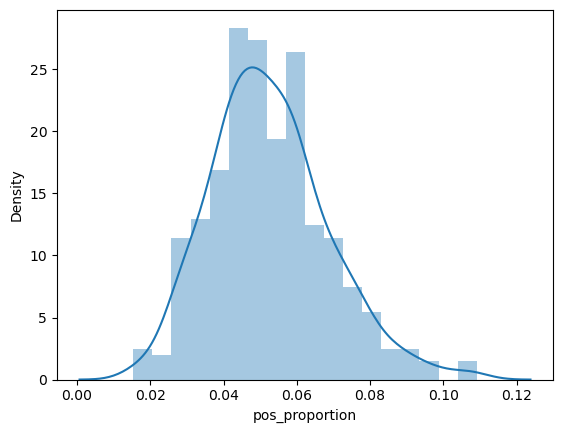

In [24]:
sns_plot = sns.distplot(data_fintone['pos_proportion'])
fig = sns_plot.get_figure()

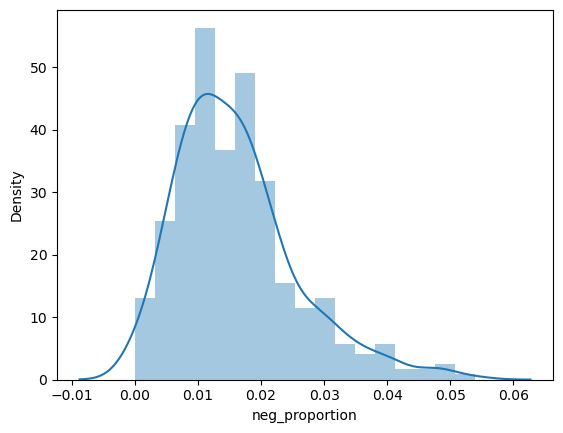

In [25]:
sns_plot = sns.distplot(data_fintone['neg_proportion'])
fig = sns_plot.get_figure()

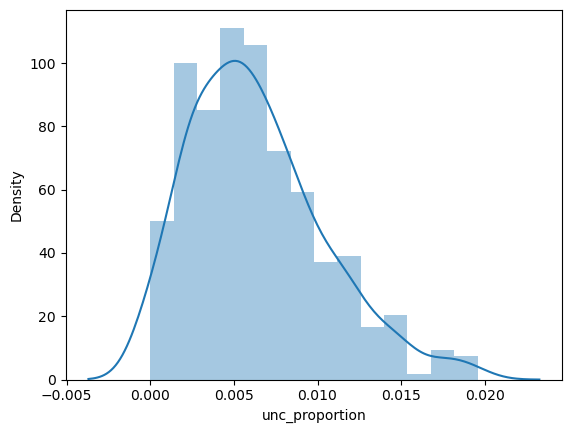

In [26]:
sns_plot = sns.distplot(data_fintone['unc_proportion'])
fig = sns_plot.get_figure()

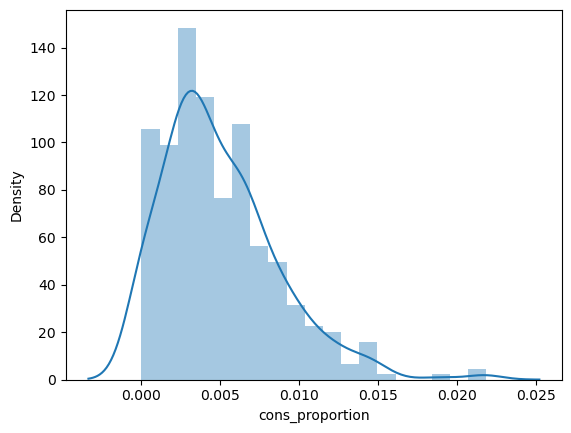

In [27]:
sns_plot = sns.distplot(data_fintone['cons_proportion'])
fig = sns_plot.get_figure()

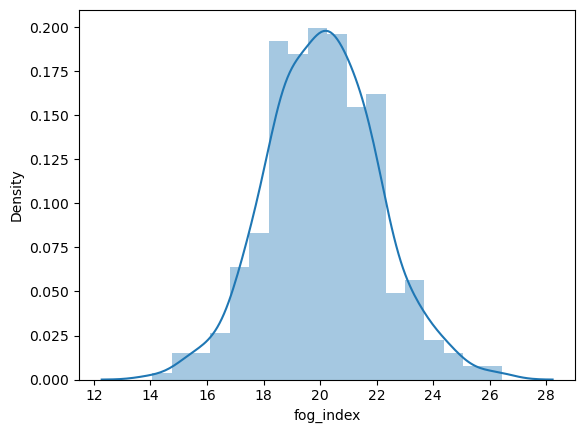

In [28]:
sns_plot = sns.distplot(data_fintone['fog_index'])
fig = sns_plot.get_figure()

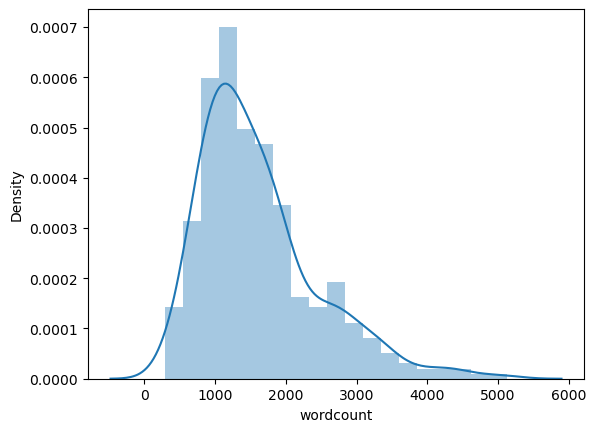

In [29]:
sns_plot = sns.distplot(data_fintone['wordcount'])
fig = sns_plot.get_figure()

In [32]:
#sns_plot = sns.distplot(data_tone['tonality'])
#fig = sns_plot.get_figure()

In [33]:
#sns_plot = sns.distplot(data_tone['lit_proportion'])
#fig = sns_plot.get_figure()

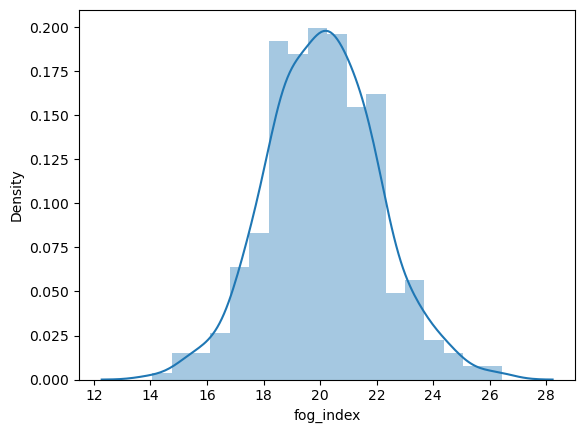

In [34]:
sns_plot = sns.distplot(data_tone['fog_index'])
fig = sns_plot.get_figure()

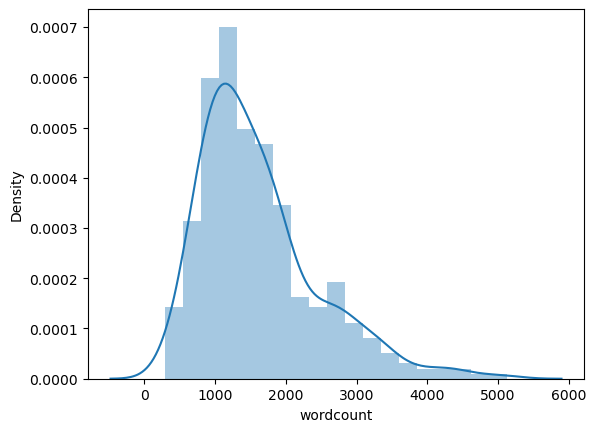

In [35]:
sns_plot = sns.distplot(data_tone['wordcount'])
fig = sns_plot.get_figure()

In [37]:
#sns_plot = sns.distplot(data_tone['complex_pr'])
#fig = sns_plot.get_figure()

In [38]:
#sns_plot = sns.distplot(data_tone['words_ps'])
#fig = sns_plot.get_figure()

## Масштабируем

In [39]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

class CustomScaler(TransformerMixin): # создаем собственный класс, опираясь на уже существующий метод
    def __init__(self, cols, scaler=None):
        self.cols = cols
        self.scaler = scaler or StandardScaler()
    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

In [40]:
sc = CustomScaler(data_fintone.columns.to_list())
data_fintone_new = sc.fit_transform(data_fintone)

data_fintone_new

,lnTA,EBITTA,NIR,FATA,lnCDCA,pos_proportion,neg_proportion,unc_proportion,cons_proportion,fog_index,wordcount
0,-0.209155,-0.177268,-0.392584,0.576862,-0.574493,-1.668923,1.310106,1.254890,-0.578438,-1.543194,-1.145028
1,-0.271557,0.219503,0.804069,0.636704,0.187720,-1.624289,1.546473,-1.566090,1.041662,-2.398649,-0.891664
2,-0.318148,0.042442,0.198533,0.533062,0.105479,-2.019435,-1.251756,-0.079127,-0.263062,-2.299208,-0.790079
3,-0.317757,0.071900,0.356669,0.320202,0.057822,-1.866707,-0.348259,-1.218434,-1.355949,-1.501421,-0.273790
4,-0.291986,0.323660,1.338082,0.109575,-0.103519,-1.516204,0.250819,-0.496379,-0.176626,-1.253025,0.213817
...,...,...,...,...,...,...,...,...,...,...,...
381,0.468884,0.003213,-0.450856,-0.326716,-1.087817,1.410968,-0.326986,-0.167227,0.606856,1.079944,2.574168
382,0.417413,0.035149,-0.414601,-0.343698,-1.042743,1.622887,-0.541002,0.409526,-0.074740,1.059998,2.843069
383,0.299730,0.018825,-0.432081,-0.355796,-1.129367,2.821416,-0.998050,-0.408595,-0.239359,0.650113,1.987367
384,0.191201,-0.016552,-0.458462,-0.444918,-1.136874,0.939005,0.244485,-0.850624,-0.435706,-0.591017,2.978117


### Обработка текста

In [41]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Загружаем стандартный список стоп-слов
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.remove('not')

In [42]:
# Добавляем в список стоп-слов названия стран
import pycountry 

for country in pycountry.countries:
    name = country.name.split(' ')
    for i in name:
        j = re.sub('[^A-Za-z]+', '', i)
        j = j.lower()
        if j not in stopwords:
            stopwords.append(j)

In [43]:
# Добавляем в список стоп-слов названия месяцев
import calendar

for month in list(calendar.month_name)[1:]:
    stopwords.append((month.lower()))

In [44]:
# Добавляем в список стоп-слов названия компаний и др. слова, 
# встречающиеся в текстах отчетов, которые можно отнести к стоп-словам

companies = ['group', 'pjsc', 'acron', 'sistema', 'aeroflot', 'beluga', 'gazprom', 'etalon',
             'lsr', 'cherkizovo', 'detsky', 'mir', 'evraz', 'lukoil', 'magnit', 'mvideo', 
             'eldorado', 'megafon', 'metalloinvest', 'mmk', 'mosenergo', 'mts', 'nlmk', 
             'novatek', 'nornickel', 'okey', 'polymetal', 'petropavlovsk', 'polyus', 
             'railways', 'rosatom', 'rosneft', 'rosseti', 'moesk', 'idgc', 'northern', 
             'caucasus', 'kuban', 'northwest', 'urals', 'center', 'volga', 'region', 
             'south', 'rostelecom', 'rostec', 'rusagro', 'rushydro', 'russneft', 'severstal', 
             'segezha', 'sovcomflot', 'suek', 'tatneft', 'tele', 'tmk', 'uralkali', 'phosagro', 
             'unipro', 'uniper', 'globaltrans', 'retail', 'x', 'synergy', 'oleniy', 'ruchey', 
             'kerch', 'safmar', 'russian', 'chinese', 'moscow', 'siberia', 'odintsovo', 
             'uk', 'us', 'usa', 'npp', 'due', 'two', 'russia', 'company', 'vorkutaugol',
            'c', 'second', 'harjavalta', 'dixy', 'fi', 'fy', 'ural', 'sverdlovsk', 'kubanenergo',
            'kv', 'rusal', 'nizhny', 'eu', 'hva', 'komi', 'one', 'kaluga', 'year', 'meat', 
             'passenger', 'oblast', 'nancial', 'pl', 'naletu', 'lenta', 'bristol', 'id', 
             'kirovsky', 'yandex', 'lavka', 'nd', 'aa', 'aaa', 'aac', 'ab', 'abc', 'ad', 
             'ag', 'ai', 'al', 'ano', 'ant', 'anton', 'antonina', 'antonios', 'antoniou', 
             'antonyan', 'ar', 'az', 'b', 'ba', 'baa', 'bb', 'bbb', 'bdd', 'bboe', 'bi', 'bf']

for company in companies:
    stopwords.append(company)

In [45]:
def data_preprocessing(text): 
    # очистка данных
    text = re.sub(re.compile('<.*?>'), '', text) 
    text =  re.sub('[^A-Za-z]+', ' ', text) 
    
    # приводим все к нижнему регистру
    text = text.lower()
    # приводим слова к токенам
    tokens = nltk.word_tokenize(text)
    # удаляем стоп-слова
    text = [word for word in tokens if word not in stopwords]
    # лемматизация
    text = [lemmatizer.lemmatize(word) for word in text]
    # соединяем слова обратно в текст
    text = ' '.join(text)
    
    return text

In [46]:
data_text['preprocessed_text'] = data_text['text'].apply(lambda text: data_preprocessing(text))
data_text = data_text.drop(columns=['text','fraud'], axis=1)
data_text.head()

,preprocessed_text
0,past true ordeal whole world covid pandemic br...
1,global mineral fertiliser market precarious pr...
2,continued pursue updated development strategy ...
3,saw positive trend mineral fertiliser market f...
4,last decade challenging year global mineral fe...


## Векторизация

In [47]:
# Создание векторизатора для текстовых данных
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                                   tokenizer=word_tokenize, 
                                   stop_words=stopwords)

# Преобразование текстовых данных в числовой формат
data_text_new = tfidf_vectorizer.fit_transform(data_text['preprocessed_text'])

In [48]:
data_text_new = pd.DataFrame(data_text_new.toarray())

In [49]:
data_combined = data_fintone_new.join(data_text_new)
data_combined.columns = data_combined.columns.astype(str)

### Деление на трейн и тест

In [50]:
y = data_fraud
x = data_combined

In [51]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.25, 
                                                    random_state=90)

## Модели

### Подбор гиперпараметров

In [52]:
lr = LogisticRegression(penalty = 'l1', solver = 'saga', 
                        random_state = 90) 
lr.fit(X_train, y_train)

params = {'C': np.arange(1,100,1)} 
grid_lr = GridSearchCV(lr, params, cv = 3, scoring = 'recall') 

grid_lr.fit(x, y)

print('best score:', grid_lr.best_score_)
print('best params:', grid_lr.best_params_)

best score: 0.09185606060606061
best params: {'C': 11}


In [53]:
knn = KNeighborsClassifier(weights = 'uniform')
knn.fit(X_train, y_train)

params = {'n_neighbors': np.arange(5,20),
          'leaf_size': np.arange(2,11)}

grid_knn = GridSearchCV(knn, params, cv = 5, scoring = 'recall') 

grid_knn.fit(x, y)

print('best score:', grid_knn.best_score_)
print('best params:', grid_knn.best_params_)

best score: 0.1331578947368421
best params: {'leaf_size': 2, 'n_neighbors': 5}


In [54]:
tree = DecisionTreeClassifier(random_state=90)
tree.fit(X_train, y_train)

params = {'max_features': ['sqrt', 'log2'],
          'max_depth': np.arange(1,20),
          'criterion': ['gini', 'entropy', 'log_loss'],
          'min_samples_leaf': np.arange(3,10)}

grid_tree = GridSearchCV(tree, params, cv = 5, scoring = 'recall') 

grid_tree.fit(x, y)

print('best score:', grid_tree.best_score_)
print('best params:', grid_tree.best_params_)

best score: 0.28947368421052627
best params: {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 3}


In [55]:
forest = RandomForestClassifier(random_state=90)
forest.fit(X_train, y_train)

params = {'max_features': ['sqrt', 'log2'],
          'n_estimators': np.arange(1,10,1),
          'max_depth' : np.arange(1,40,1),
          'criterion': ['gini', 'entropy', 'log_loss']}

grid_forest = GridSearchCV(forest, params, cv = 5, 
                           scoring = 'recall') 

grid_forest.fit(x, y)

print('best score:', grid_forest.best_score_)
print('best params:', grid_forest.best_params_)

best score: 0.32105263157894737
best params: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 2}


In [56]:
svm = SVC(random_state = 90)
svm.fit(X_train, y_train)

params = {'C': np.arange(0.01,1.01,0.01),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_svm = GridSearchCV(svm, params, cv = 5, scoring = 'recall')
grid_svm.fit(x, y)

print('Best params:', grid_svm.best_params_)
print('Best Score:', grid_svm.best_score_)

Best params: {'C': 0.86, 'kernel': 'linear'}
Best Score: 0.12263157894736842


### Предсказание мошенничества для каждой модели

In [57]:
# Логистическая регрессия
lr_model = LogisticRegression(penalty = 'l1', solver = 'saga', 
                        random_state = 90, C = 11) 

lr_model.fit(X_train, y_train)

lr_pred_train = lr_model.predict(X_train)
lr_pred_test = lr_model.predict(X_test)
lr_pred = lr_model.predict(x)

In [58]:
# K ближайших соседей
knn_model = KNeighborsClassifier(leaf_size = 2, n_neighbors = 5, weights = 'uniform')

knn_model.fit(X_train, y_train)

knn_pred_train = knn_model.predict(X_train)
knn_pred_test = knn_model.predict(X_test)
knn_pred = knn_model.predict(x)

In [59]:
# Дерево решений
tree_model = DecisionTreeClassifier(random_state=90, criterion = 'gini', 
                                    max_depth = 18, max_features = 'sqrt', 
                                    min_samples_leaf = 3)
tree_model.fit(X_train, y_train)

tree_pred_train = tree_model.predict(X_train)
tree_pred_test = tree_model.predict(X_test)
tree_pred = tree_model.predict(x)

In [60]:
# Случайный лес
forest_model = RandomForestClassifier(random_state=90, criterion = 'gini', max_depth = 15,
                               max_features = 'sqrt', n_estimators = 2)
forest_model.fit(X_train, y_train)

forest_pred_train = forest_model.predict(X_train)
forest_pred_test = forest_model.predict(X_test)
forest_pred = forest_model.predict(x)

In [61]:
# Метод опорных векторов
svm_model = SVC(random_state = 90, C = 0.86, kernel = 'linear', probability=True)
svm_model.fit(X_train, y_train)

svm_pred_train = svm_model.predict(X_train)
svm_pred_test = svm_model.predict(X_test)
svm_pred = svm_model.predict(x)

### Подсчет основных метрик качества для каждой модели

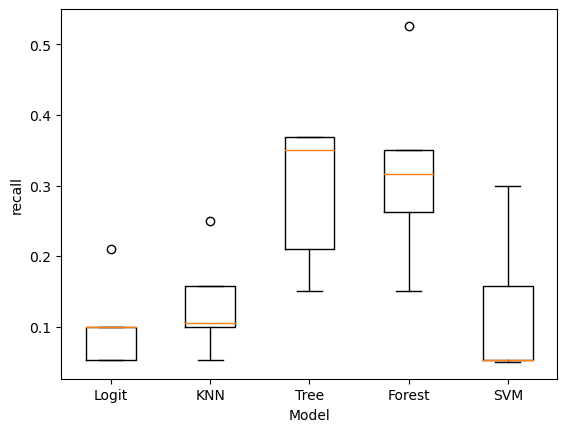

In [66]:
#Log
cv_log_best = cross_validate(lr_model, x, y, cv = 5, scoring = 'recall')

#KNN
cv_knn_best = cross_validate(knn_model, x, y, cv = 5, scoring = 'recall')
    
#Tree
cv_tree_best = cross_validate(tree_model, x, y, cv = 5, scoring = 'recall')

#Forest
cv_forest_best = cross_validate(forest_model, x, y, cv = 5, scoring = 'recall')

#SVM
cv_svm_best = cross_validate(svm_model, x, y, cv = 5, scoring = 'recall')

dt = [cv_log_best['test_score'], cv_knn_best['test_score'], cv_tree_best['test_score'], 
      cv_forest_best['test_score'], cv_svm_best['test_score']]

labels = ['Logit', 'KNN', 'Tree', 'Forest', 'SVM']

plt.boxplot(dt)
plt.xticks([1, 2, 3, 4, 5], labels)
plt.xlabel("Model")
plt.ylabel("recall")
plt.show()

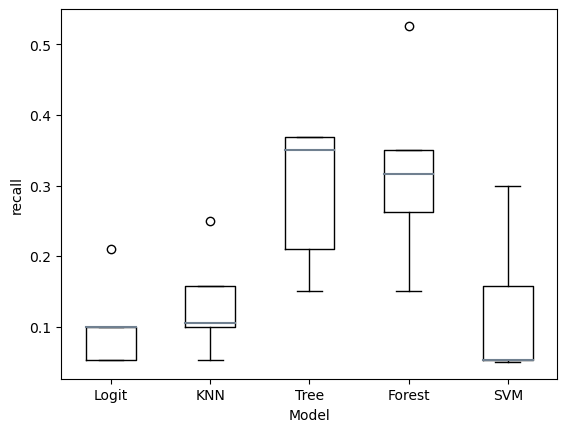

In [63]:
plt.boxplot(dt, medianprops = dict(color = "slategrey", linewidth = 1.5))
plt.xticks([1, 2, 3, 4, 5], labels)
plt.xlabel("Model")
plt.ylabel("recall")
plt.show()

In [64]:
precisions, recalls, f1scores, accuracys, rocaucs = [], [], [], [], []

def data(score):
    cv_log_best = cross_validate(lr_model, x, y, cv = 5, scoring = score)
    cv_knn_best = cross_validate(knn_model, x, y, cv = 5, scoring = score)
    cv_tree_best = cross_validate(tree_model, x, y, cv = 5, scoring = score)
    cv_forest_best = cross_validate(forest_model, x, y, cv = 5, scoring = score)
    cv_svm_best = cross_validate(svm_model, x, y, cv = 5, scoring = score)
    return [cv_log_best['test_score'], cv_knn_best['test_score'], cv_tree_best['test_score'], 
            cv_forest_best['test_score'], cv_svm_best['test_score']]

def average(data, frame):
    for i in data:
        average = 0
        for j in i:
            average += j
        average = average / 5
        frame.append(average)
    return frame

average(data('precision'), precisions)
average(data('recall'), recalls)
average(data('roc_auc'), rocaucs)
average(data('f1'), f1scores)
average(data('accuracy'), accuracys)

[0.7279054279054279,
 0.6812520812520813,
 0.6423909423909424,
 0.5518481518481517,
 0.6733266733266733]

In [68]:
model = ['lr', 'knn', 'tree', 'forest', 'svm']
metrics_cv = pd.DataFrame({'f1_score': f1scores, 'precision': precisions, 'recall': recalls, 'ROC AUC': rocaucs, 
                        'accuracy': accuracys}, index=model)
metrics_cv

,f1_score,precision,recall,ROC AUC,accuracy
lr,0.150742,0.547059,0.103158,0.548981,0.727905
knn,0.175229,0.275000,0.133158,0.421942,0.681252
tree,0.282628,0.285459,0.289474,0.536431,0.642391
forest,0.255010,0.218795,0.321053,0.483790,0.551848
svm,0.160796,0.400952,0.122632,0.487786,0.673327


In [69]:
print(metrics_cv.max())

f1_score     0.282628
precision    0.547059
recall       0.321053
ROC AUC      0.548981
accuracy     0.727905
dtype: float64


## Метрики для лучшей модели

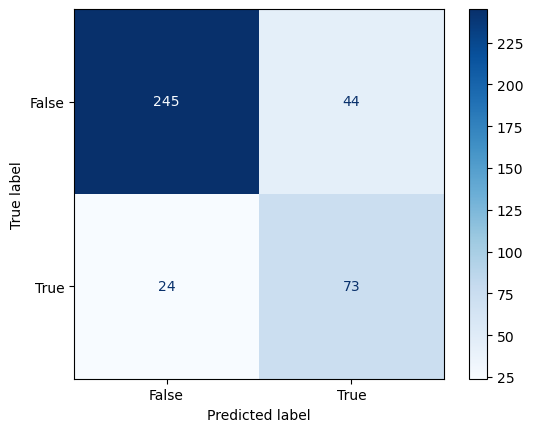

In [70]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, forest_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

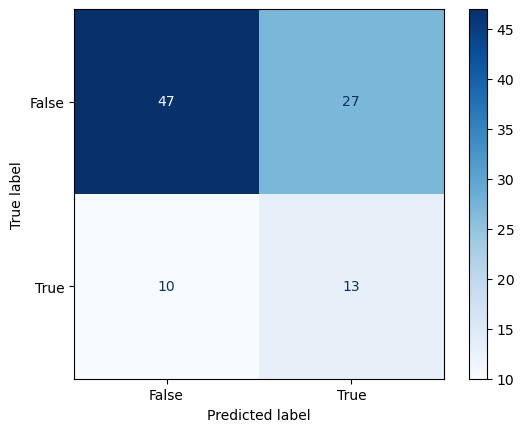

In [71]:
confusion_matrix = metrics.confusion_matrix(y_test, forest_pred_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [72]:
print('', 'accuracy train forest:', accuracy_score(y_train,forest_pred_train), '\n',
      'accuracy test forest:', accuracy_score(y_test,forest_pred_test)) 
print('\n', 'precision train forest:', precision_score(y_train,forest_pred_train), '\n',
      'precision test forest:', precision_score(y_test,forest_pred_test)) 
print('\n', 'recall train forest:', recall_score(y_train,forest_pred_train), '\n',
      'recall test forest:', recall_score(y_test,forest_pred_test)) 
print('\n', 'f1-score train forest:', f1_score(y_train,forest_pred_train), '\n',
      'f1-score test forest:', f1_score(y_test,forest_pred_test)) 
print('\n', 'roc_auc train forest:', roc_auc_score(y_train,forest_pred_train),  '\n',
      'roc_auc test forest:', roc_auc_score(y_test,forest_pred_test), '\n')

print('accuracy forest:', accuracy_score(y,forest_pred))
print('precision forest:', precision_score(y,forest_pred))
print('recall forest:', recall_score(y,forest_pred))
print('f1-score forest:', f1_score(y,forest_pred))
print('roc_auc forest:', roc_auc_score(y,forest_pred))

 accuracy train forest: 0.8927335640138409 
 accuracy test forest: 0.6185567010309279

 precision train forest: 0.7792207792207793 
 precision test forest: 0.325

 recall train forest: 0.8108108108108109 
 recall test forest: 0.5652173913043478

 f1-score train forest: 0.794701986754967 
 f1-score test forest: 0.4126984126984127

 roc_auc train forest: 0.8658705216844752 
 roc_auc test forest: 0.6001762632197414 

accuracy forest: 0.8238341968911918
precision forest: 0.6239316239316239
recall forest: 0.7525773195876289
f1-score forest: 0.6822429906542056
roc_auc forest: 0.800164092319766


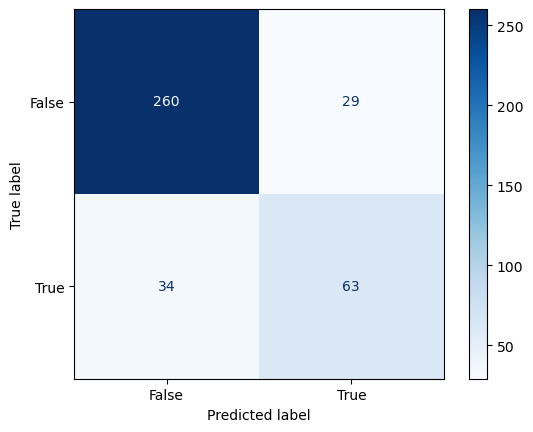

In [73]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, tree_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [74]:
print('', 'accuracy train tree:', accuracy_score(y_train,tree_pred_train), '\n',
      'accuracy test tree:', accuracy_score(y_test,tree_pred_test)) 
print('\n', 'precision train tree:', precision_score(y_train,tree_pred_train), '\n',
      'precision test tree:', precision_score(y_test,tree_pred_test)) 
print('\n', 'recall train tree:', recall_score(y_train,tree_pred_train), '\n',
      'recall test tree:', recall_score(y_test,tree_pred_test)) 
print('\n', 'f1-score train tree:', f1_score(y_train,tree_pred_train), '\n',
      'f1-score test tree:', f1_score(y_test,tree_pred_test)) 
print('\n', 'roc_auc train tree:', roc_auc_score(y_train,tree_pred_train),  '\n',
      'roc_auc test tree:', roc_auc_score(y_test,tree_pred_test), '\n')

print('accuracy tree:', accuracy_score(y,tree_pred))
print('precision tree:', precision_score(y,tree_pred))
print('recall tree:', recall_score(y,tree_pred))
print('f1-score tree:', f1_score(y,tree_pred))
print('roc_auc tree:', roc_auc_score(y,tree_pred))

 accuracy train tree: 0.903114186851211 
 accuracy test tree: 0.6391752577319587

 precision train tree: 0.8382352941176471 
 precision test tree: 0.25

 recall train tree: 0.7702702702702703 
 recall test tree: 0.2608695652173913

 f1-score train tree: 0.8028169014084507 
 f1-score test tree: 0.2553191489361702

 roc_auc train tree: 0.8595537397862979 
 roc_auc test tree: 0.5088131609870741 

accuracy tree: 0.8367875647668394
precision tree: 0.6847826086956522
recall tree: 0.6494845360824743
f1-score tree: 0.6666666666666666
roc_auc tree: 0.7745692576606142


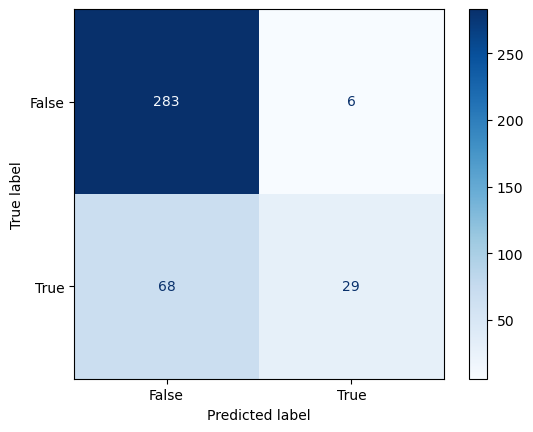

In [75]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, lr_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [76]:
print('', 'accuracy train log:', accuracy_score(y_train,lr_pred_train), '\n',
      'accuracy test log:', accuracy_score(y_test,lr_pred_test)) 
print('\n', 'precision train log:', precision_score(y_train,lr_pred_train), '\n',
      'precision test log:', precision_score(y_test,lr_pred_test)) 
print('\n', 'recall train log:', recall_score(y_train,lr_pred_train), '\n',
      'recall test log:', recall_score(y_test,lr_pred_test)) 
print('\n', 'f1-score train log:', f1_score(y_train,lr_pred_train), '\n',
      'f1-score test log:', f1_score(y_test,lr_pred_test)) 
print('\n', 'roc_auc train log:', roc_auc_score(y_train,lr_pred_train),  '\n',
      'roc_auc test log:', roc_auc_score(y_test,lr_pred_test), '\n')

print('accuracy log:', accuracy_score(y,lr_pred))
print('precision log:', precision_score(y,lr_pred))
print('recall log:', recall_score(y,lr_pred))
print('f1-score log:', f1_score(y,lr_pred))
print('roc_auc log:', roc_auc_score(y,lr_pred))

 accuracy train log: 0.8131487889273357 
 accuracy test log: 0.7938144329896907

 precision train log: 0.8846153846153846 
 precision test log: 0.6666666666666666

 recall train log: 0.3108108108108108 
 recall test log: 0.2608695652173913

 f1-score train log: 0.46 
 f1-score test log: 0.37500000000000006

 roc_auc train log: 0.6484286612193589 
 roc_auc test log: 0.6101645123384254 

accuracy log: 0.8082901554404145
precision log: 0.8285714285714286
recall log: 0.29896907216494845
f1-score log: 0.4393939393939394
roc_auc log: 0.639103913245104


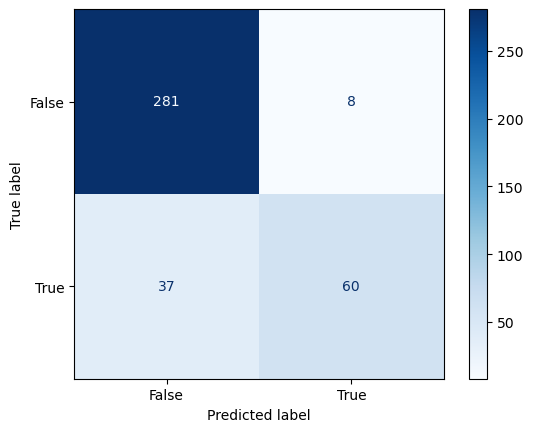

In [77]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, svm_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [78]:
print('', 'accuracy train svm:', accuracy_score(y_train,svm_pred_train), '\n',
      'accuracy test svm:', accuracy_score(y_test,svm_pred_test)) 
print('\n', 'precision train svm:', precision_score(y_train,svm_pred_train), '\n',
      'precision test svm:', precision_score(y_test,svm_pred_test)) 
print('\n', 'recall train svm:', recall_score(y_train,svm_pred_train), '\n',
      'recall test svm:', recall_score(y_test,svm_pred_test)) 
print('\n', 'f1-score train svm:', f1_score(y_train,svm_pred_train), '\n',
      'f1-score test svm:', f1_score(y_test,svm_pred_test)) 
print('\n', 'roc_auc train svm:', roc_auc_score(y_train,svm_pred_train),  '\n',
      'roc_auc test svm:', roc_auc_score(y_test,svm_pred_test), '\n')

print('accuracy svm:', accuracy_score(y,svm_pred))
print('precision svm:', precision_score(y,svm_pred))
print('recall svm:', recall_score(y,svm_pred))
print('f1-score svm:', f1_score(y,svm_pred))
print('roc_auc svm:', roc_auc_score(y,svm_pred))

 accuracy train svm: 0.9204152249134948 
 accuracy test svm: 0.7731958762886598

 precision train svm: 0.9473684210526315 
 precision test svm: 0.5454545454545454

 recall train svm: 0.7297297297297297 
 recall test svm: 0.2608695652173913

 f1-score train svm: 0.8244274809160306 
 f1-score test svm: 0.3529411764705882

 roc_auc train svm: 0.8578881206788184 
 roc_auc test svm: 0.5966509988249119 

accuracy svm: 0.883419689119171
precision svm: 0.8823529411764706
recall svm: 0.6185567010309279
f1-score svm: 0.7272727272727274
roc_auc svm: 0.7954375200656371


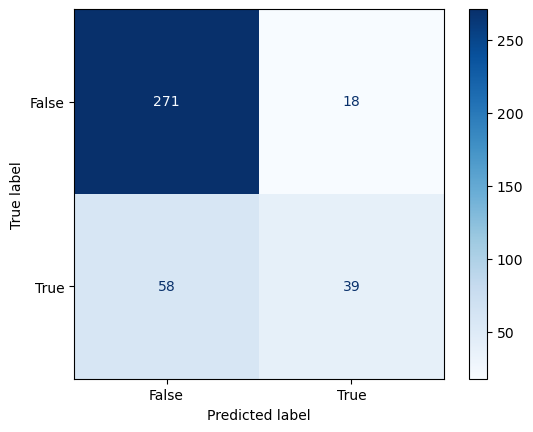

In [79]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, knn_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [80]:
print('', 'accuracy train knn:', accuracy_score(y_train,knn_pred_train), '\n',
      'accuracy test knn:', accuracy_score(y_test,knn_pred_test)) 
print('\n', 'precision train knn:', precision_score(y_train,knn_pred_train), '\n',
      'precision test knn:', precision_score(y_test,knn_pred_test)) 
print('\n', 'recall train knn:', recall_score(y_train,knn_pred_train), '\n',
      'recall test knn:', recall_score(y_test,knn_pred_test)) 
print('\n', 'f1-score train knn:', f1_score(y_train,knn_pred_train), '\n',
      'f1-score test knn:', f1_score(y_test,knn_pred_test)) 
print('\n', 'roc_auc train knn:', roc_auc_score(y_train,knn_pred_train),  '\n',
      'roc_auc test knn:', roc_auc_score(y_test,knn_pred_test), '\n')

print('accuracy knn:', accuracy_score(y,knn_pred))
print('precision knn:', precision_score(y,knn_pred))
print('recall knn:', recall_score(y,knn_pred))
print('f1-score knn:', f1_score(y,knn_pred))
print('roc_auc knn:', roc_auc_score(y,knn_pred))

 accuracy train knn: 0.8096885813148789 
 accuracy test knn: 0.7835051546391752

 precision train knn: 0.7111111111111111 
 precision test knn: 0.5833333333333334

 recall train knn: 0.43243243243243246 
 recall test knn: 0.30434782608695654

 f1-score train knn: 0.5378151260504201 
 f1-score test knn: 0.4

 roc_auc train knn: 0.6859836580766813 
 roc_auc test knn: 0.6183901292596945 

accuracy knn: 0.8031088082901554
precision knn: 0.6842105263157895
recall knn: 0.4020618556701031
f1-score knn: 0.5064935064935066
roc_auc knn: 0.6698890593229408


In [84]:
# Извлекаем значимость параметров
#fi1 = pd.DataFrame({'feature': ['lnTA', 'EBITTA', 'NIR', 'FATA', 
#                                'lnCDCA', 'pos_proportion',
#                                'neg_proportion', 'unc_proportion',
#                                'cons_proportion', 'fog_index',
#                                'wordcount'],
#                   'importance': forest_model.feature_importances_}).\
#                    sort_values('importance', ascending = False)

# Выводим значения
#fi1.head()

In [86]:
#forest_model.feature_importances_[:11]

### Гипотезы 1-4

In [89]:
x_new = x.iloc [:, 0:11]
x_train_new = X_train.iloc [:, 0:11]
x_test_new = X_test.iloc [:, 0:11]

In [90]:
x_new

,lnTA,EBITTA,NIR,FATA,lnCDCA,pos_proportion,neg_proportion,unc_proportion,cons_proportion,fog_index,wordcount
0,-0.209155,-0.177268,-0.392584,0.576862,-0.574493,-1.668923,1.310106,1.254890,-0.578438,-1.543194,-1.145028
1,-0.271557,0.219503,0.804069,0.636704,0.187720,-1.624289,1.546473,-1.566090,1.041662,-2.398649,-0.891664
2,-0.318148,0.042442,0.198533,0.533062,0.105479,-2.019435,-1.251756,-0.079127,-0.263062,-2.299208,-0.790079
3,-0.317757,0.071900,0.356669,0.320202,0.057822,-1.866707,-0.348259,-1.218434,-1.355949,-1.501421,-0.273790
4,-0.291986,0.323660,1.338082,0.109575,-0.103519,-1.516204,0.250819,-0.496379,-0.176626,-1.253025,0.213817
...,...,...,...,...,...,...,...,...,...,...,...
381,0.468884,0.003213,-0.450856,-0.326716,-1.087817,1.410968,-0.326986,-0.167227,0.606856,1.079944,2.574168
382,0.417413,0.035149,-0.414601,-0.343698,-1.042743,1.622887,-0.541002,0.409526,-0.074740,1.059998,2.843069
383,0.299730,0.018825,-0.432081,-0.355796,-1.129367,2.821416,-0.998050,-0.408595,-0.239359,0.650113,1.987367
384,0.191201,-0.016552,-0.458462,-0.444918,-1.136874,0.939005,0.244485,-0.850624,-0.435706,-0.591017,2.978117


In [91]:
forest_model1 = RandomForestClassifier(random_state=90, criterion = 'gini', max_depth = 12,
                               max_features = 'sqrt', n_estimators = 3)
forest_model1.fit(x_train_new, y_train)

RandomForestClassifier(max_depth=12, n_estimators=3, random_state=90)

In [93]:
import subprocess

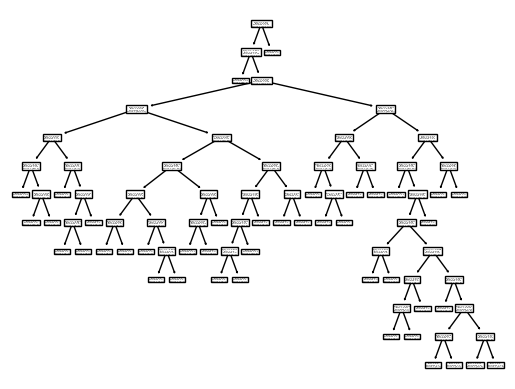

In [94]:
from sklearn import tree

# Extract single tree
estimator = forest_model1.estimators_[0]

tree.plot_tree(estimator)
plt.savefig('saved_figure.png', dpi = 1000)

In [95]:
x_h0 = x_new.drop(columns=['pos_proportion', 'neg_proportion', 'fog_index', 'wordcount'], axis=1)
x_train_h0 = x_train_new.drop(columns=['pos_proportion', 'neg_proportion', 'fog_index', 'wordcount'], axis=1)
x_test_h0 = x_test_new.drop(columns=['pos_proportion', 'neg_proportion', 'fog_index', 'wordcount'], axis=1)

In [96]:
# Случайный лес - гип 1
forest_model1 = RandomForestClassifier(random_state=90, criterion = 'gini', max_depth = 12,
                               max_features = 'sqrt', n_estimators = 3)
forest_model1.fit(x_train_h0, y_train)

forest_pred_train = forest_model1.predict(x_train_h0)
forest_pred_test = forest_model1.predict(x_test_h0)
forest_pred = forest_model1.predict(x_h0)

In [97]:
print('accuracy forest:', accuracy_score(y,forest_pred))
print('precision forest:', precision_score(y,forest_pred))
print('recall forest:', recall_score(y,forest_pred))
print('f1-score forest:', f1_score(y,forest_pred))
print('roc_auc forest:', roc_auc_score(y,forest_pred))

accuracy forest: 0.8937823834196891
precision forest: 0.8181818181818182
recall forest: 0.7422680412371134
f1-score forest: 0.7783783783783784
roc_auc forest: 0.8434523597189028


In [98]:
x_h1 = x_new.drop(columns=['neg_proportion', 'fog_index', 'wordcount'], axis=1)
x_train_h1 = x_train_new.drop(columns=['neg_proportion', 'fog_index', 'wordcount'], axis=1)
x_test_h1 = x_test_new.drop(columns=['neg_proportion', 'fog_index', 'wordcount'], axis=1)

In [99]:
# Случайный лес - гип 1
forest_modelh1 = RandomForestClassifier(random_state=90, criterion = 'gini', max_depth = 12,
                               max_features = 'sqrt', n_estimators = 3)
forest_modelh1.fit(x_train_h1, y_train)

forest_h1_train = forest_modelh1.predict(x_train_h1)
forest_h1_test = forest_modelh1.predict(x_test_h1)
forest_h1pred = forest_modelh1.predict(x_h1)

In [100]:
print('accuracy без pos_proportion:', accuracy_score(y,forest_h1pred))
print('precision без pos_proportion:', precision_score(y,forest_h1pred))
print('recall без pos_proportion:', recall_score(y,forest_h1pred))
print('f1-score без pos_proportion:', f1_score(y,forest_h1pred))
print('roc_auc без pos_proportion:', roc_auc_score(y,forest_h1pred))

accuracy без pos_proportion: 0.8963730569948186
precision без pos_proportion: 0.8275862068965517
recall без pos_proportion: 0.7422680412371134
f1-score без pos_proportion: 0.782608695652174
roc_auc без pos_proportion: 0.845182463525131


In [101]:
x_h2 = x_new.drop(columns=['pos_proportion', 'fog_index', 'wordcount'], axis=1)
x_train_h2 = x_train_new.drop(columns=['pos_proportion', 'fog_index', 'wordcount'], axis=1)
x_test_h2 = x_test_new.drop(columns=['pos_proportion', 'fog_index', 'wordcount'], axis=1)

In [102]:
# Случайный лес - гип 2
forest_modelh2 = RandomForestClassifier(random_state=90, criterion = 'gini', max_depth = 12,
                               max_features = 'sqrt', n_estimators = 3)
forest_modelh2.fit(x_train_h2, y_train)

forest_h2_train = forest_modelh2.predict(x_train_h2)
forest_h2_test = forest_modelh2.predict(x_test_h2)
forest_h2pred = forest_modelh2.predict(x_h2)

In [103]:
print('accuracy только с neg_proportion:', accuracy_score(y,forest_h2pred))
print('precision только с neg_proportion:', precision_score(y,forest_h2pred))
print('recall только с neg_proportion:', recall_score(y,forest_h2pred))
print('f1-score только с neg_proportion:', f1_score(y,forest_h2pred))
print('roc_auc только с neg_proportion:', roc_auc_score(y,forest_h2pred))

accuracy только с neg_proportion: 0.8886010362694301
precision только с neg_proportion: 0.8375
recall только с neg_proportion: 0.6907216494845361
f1-score только с neg_proportion: 0.7570621468926554
roc_auc только с neg_proportion: 0.8228694752612992


In [104]:
x_h3 = x_new.drop(columns=['pos_proportion', 'fog_index', 'neg_proportion'], axis=1)
x_train_h3 = x_train_new.drop(columns=['pos_proportion', 'fog_index', 'neg_proportion'], axis=1)
x_test_h3 = x_test_new.drop(columns=['pos_proportion', 'fog_index', 'neg_proportion'], axis=1)

In [105]:
# Случайный лес - гип 3
forest_modelh3 = RandomForestClassifier(random_state=90, criterion = 'gini', max_depth = 12,
                               max_features = 'sqrt', n_estimators = 3)
forest_modelh3.fit(x_train_h3, y_train)

forest_h3_train = forest_modelh3.predict(x_train_h3)
forest_h3_test = forest_modelh3.predict(x_test_h3)
forest_h3pred = forest_modelh3.predict(x_h3)

In [106]:
print('accuracy только с wordcount:', accuracy_score(y,forest_h3pred))
print('precision только с wordcount:', precision_score(y,forest_h3pred))
print('recall только с wordcount:', recall_score(y,forest_h3pred))
print('f1-score только с wordcount:', f1_score(y,forest_h3pred))
print('roc_auc только с wordcount:', roc_auc_score(y,forest_h3pred))

accuracy только с wordcount: 0.8963730569948186
precision только с wordcount: 0.8131868131868132
recall только с wordcount: 0.7628865979381443
f1-score только с wordcount: 0.7872340425531914
roc_auc только с wordcount: 0.8520315342631898


In [107]:
x_h4 = x_new.drop(columns=['pos_proportion', 'wordcount', 'neg_proportion'], axis=1)
x_train_h4 = x_train_new.drop(columns=['pos_proportion', 'wordcount', 'neg_proportion'], axis=1)
x_test_h4 = x_test_new.drop(columns=['pos_proportion', 'wordcount', 'neg_proportion'], axis=1)

In [108]:
# Случайный лес - гип 4
forest_modelh4 = RandomForestClassifier(random_state=90, criterion = 'gini', max_depth = 12,
                               max_features = 'sqrt', n_estimators = 3)
forest_modelh4.fit(x_train_h4, y_train)

forest_h4_train = forest_modelh4.predict(x_train_h4)
forest_h4_test = forest_modelh4.predict(x_test_h4)
forest_h4pred = forest_modelh4.predict(x_h4)

In [109]:
print('accuracy только с fog_index:', accuracy_score(y,forest_h4pred))
print('precision только с fog_index:', precision_score(y,forest_h4pred))
print('recall только с fog_index:', recall_score(y,forest_h4pred))
print('f1-score только с fog_index:', f1_score(y,forest_h4pred))
print('roc_auc только с fog_index:', roc_auc_score(y,forest_h4pred))

accuracy только с fog_index: 0.8808290155440415
precision только с fog_index: 0.8227848101265823
recall только с fog_index: 0.6701030927835051
f1-score только с fog_index: 0.7386363636363636
roc_auc только с fog_index: 0.8108300931045553


In [112]:
# Извлекаем значимость параметров
#fi1 = pd.DataFrame({'feature': ['lnTA', 'EBITTA', 'NIR', 'FATA', 
#                                'lnCDCA', 'pos_proportion',
#                                'neg_proportion', 'unc_proportion',
#                                'cons_proportion', 'fog_index',
#                                'wordcount'],
#                   'importance': forest_model1.feature_importances_}).\
#                    sort_values('importance', ascending = False)

# Выводим значения
#fi1

In [113]:
#fi1.sort_values(by='importance', ascending=False)

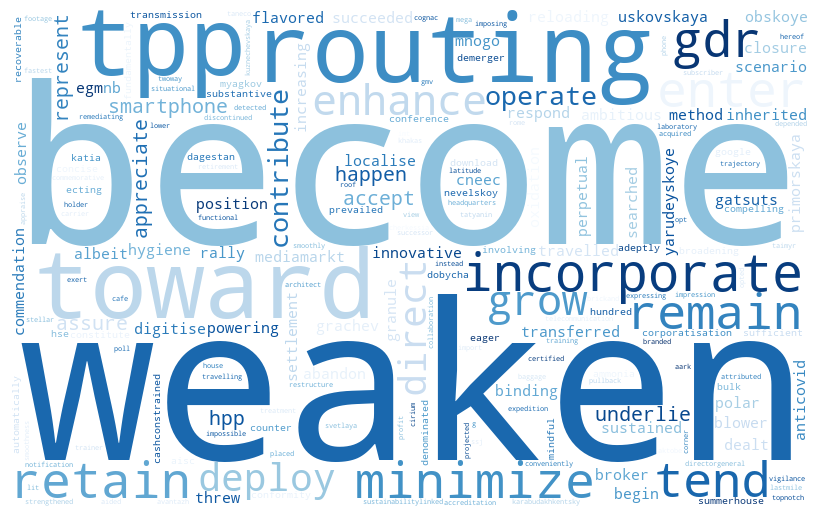

In [117]:
from wordcloud import WordCloud
wordsf = " ".join(fraudwords)

wordcloudf = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(wordsf)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloudf)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

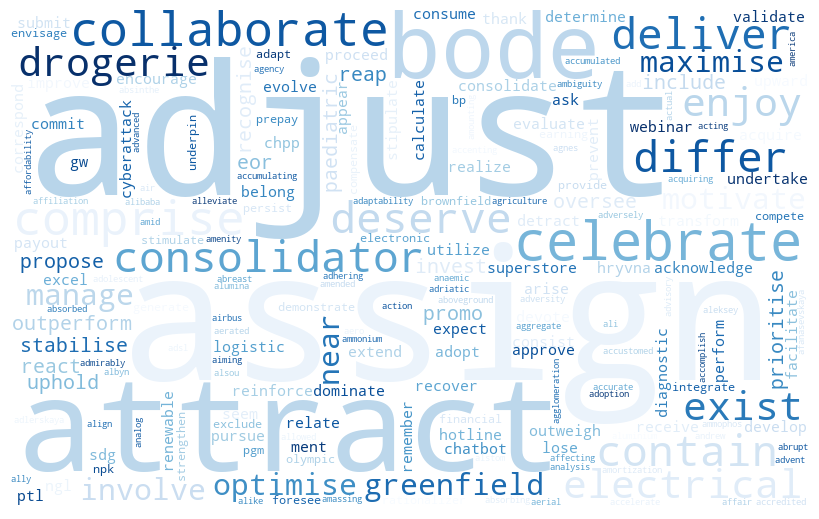

In [118]:
wordsn = " ".join(nonfraudwords)

wordcloudn = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(wordsn)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloudn)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

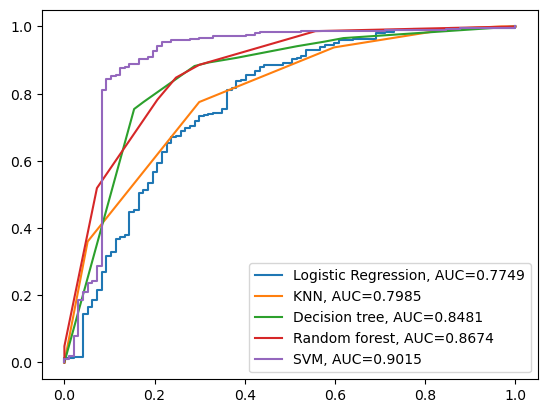

In [119]:
from sklearn.metrics import roc_curve, auc

tpr, fpr, _ = roc_curve(y, lr_model.predict_proba(x)[:, 0])
pred_lr = lr_model.predict_proba (x)[:, 1]
auc = round(metrics. roc_auc_score (y, pred_lr), 4)
plt.plot (fpr,tpr,label="Logistic Regression, AUC="+str(auc))

tpr, fpr, _ = roc_curve(y, knn_model.predict_proba(x)[:, 0])
pred_knn = knn_model.predict_proba (x)[:, 1]
auc = round(metrics. roc_auc_score (y, pred_knn), 4)
plt.plot (fpr,tpr,label="KNN, AUC="+str(auc))

tpr, fpr, _ = roc_curve(y, tree_model.predict_proba(x)[:, 0])
pred_tree = tree_model.predict_proba (x)[:, 1]
auc = round(metrics. roc_auc_score (y, pred_tree), 4)
plt.plot (fpr,tpr,label="Decision tree, AUC="+str(auc))

tpr, fpr, _ = roc_curve(y, forest_model.predict_proba(x)[:, 0])
pred_forest = forest_model.predict_proba (x)[:, 1]
auc = round(metrics. roc_auc_score (y, pred_forest), 4)
plt.plot (fpr,tpr,label="Random forest, AUC="+str(auc))

tpr, fpr, _ = roc_curve(y, svm_model.predict_proba(x)[:, 0])
pred_svm = svm_model.predict_proba (x)[:, 1]
auc = round(metrics. roc_auc_score (y, pred_svm), 4)
plt.plot (fpr,tpr,label="SVM, AUC="+str(auc))


plt.legend() 